 $\Large \textbf{CONSTRUCTING PREDICTION SETS WITH ACP}$

This notebook provides an introductory tutorial on Approximate full Conformal Prediction (ACP). The full details can be found in the accompanying paper:

Javier Abad, Umang Bhatt, Adrian Weller and Giovanni Cherubin. “Approximating Full Conformal Prediction at Scale via Influence Functions.” 2022.

$\textbf{CONSTRUCTING VALID PREDICTION SETS}$

Consider a training set $Z=(X, Y) \in(\mathcal{X} \times \mathcal{Y})^{N}$ of $N$ examples. For a test example $x \in \mathcal{X}$ and a chosen significance level $\varepsilon \in[0,1]$ a Conformal Predictor (CP) returns a set $\Gamma^{e} \subseteq \mathcal{Y}$ that contains $x$’s true label with probability at least $1-\varepsilon$. This guarantee (validity) holds for any exchangeable distribution on $Z \cup\{(x, y)\}$.

Particularly, full CP is a statistically powerful CP algorithm that attains the validity guarantees while also yielding tight prediction sets (i.e., high efficiency). Unfortunately,  full CP is notoriously computationally expensive. 

ACP consistently approximates full CP by leveraging Influence Functions (IF). Given a sufficiently large training set, ACP inherits the statistical power of full CP. This enables running full CP at a much reduced computational cost, and allows scaling it to large, real-world datasets. 

$\textbf{IMPORTING THE PACKAGES}$

In [1]:
from wrapper import *
from utils import *

SEED = 42 #for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

Using cuda device


$\textbf{DATA}$

We generate synthetic data for a 5-class classification problem using scikit-learn’s $\texttt{make_classification}() $. We sample points from five Gaussian-distributed clusters, one per class. Each object is defined by 10 features. This is a concrete toy example, but feel free to play around with different synthetic settings!

In [2]:
TRAIN_SIZE = 1000 #number of training points
TEST_SIZE = 10 #number of test points
N_CLASSES = 5 #number of classes
N_FEATURES = 10 #total number of features 
N_CLUSTERS = 1 #number of clusters per class
N_INFORMATIVE = 3 #number of informative features
N_REDUNDANT = 2 #number of redundant features

X, Y = make_classification(n_samples = TRAIN_SIZE + TEST_SIZE, n_features = N_FEATURES, n_classes = N_CLASSES,
                           n_clusters_per_class = N_CLUSTERS, n_informative = N_INFORMATIVE, random_state = SEED)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = TEST_SIZE, random_state = SEED)

$\textbf{FITTING A MODEL}$

It’s time to decide the underlying model on top of which we build ACP. Here we use a 2-layers neural network; however, you can plug in any model as long as it is differentiable.

In [3]:
#Instantiate model

NUM_NEURONS = [20,10] #layers and neurons for the NN classifier
REG = 0.01
model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES, seed = SEED, l2_reg = REG)

$\textbf{BUILDING ACP AND GENERATING PREDICTION SETS}$

ACP works as a wrapper for an ML model. We now instantiate ACP and generate prediction sets for a chosen significance level $\varepsilon$. These prediction sets are guaranteed to contain the true class label with confidence at least $1 – \varepsilon$.

In [4]:
#Building ACP (deleted)
ACP = ACP_D(Xtrain, Ytrain, model, seed = SEED, verbose = True)

Training model on 1000 samples
Epoch: 1 - Validation Loss: 2.6290
Epoch: 10 - Validation Loss: 2.0676
Epoch: 20 - Validation Loss: 1.7236
Epoch: 30 - Validation Loss: 1.4719
Epoch: 40 - Validation Loss: 1.3131
Epoch: 50 - Validation Loss: 1.2087
Epoch: 60 - Validation Loss: 1.1295
Epoch: 70 - Validation Loss: 1.0662
Epoch: 80 - Validation Loss: 1.0187
Epoch: 90 - Validation Loss: 0.9798
Epoch: 100 - Validation Loss: 0.9498
Epoch: 110 - Validation Loss: 0.9248
Epoch: 120 - Validation Loss: 0.9041
Epoch: 130 - Validation Loss: 0.8853
Epoch: 140 - Validation Loss: 0.8728
Epoch: 150 - Validation Loss: 0.8595
Epoch: 160 - Validation Loss: 0.8501
Epoch: 170 - Validation Loss: 0.8418
Epoch: 180 - Validation Loss: 0.8322
Epoch: 190 - Validation Loss: 0.8271
Epoch: 200 - Validation Loss: 0.8186
Computing gradients and Hessian inverse
Computing scores for 1000 samples
Conformal predictor is ready!


In [5]:
#Generate prediction sets that are guaranteed to contain the true class label with at least a specified probability 1-epsilon
eps = 0.1 # 1-0.1 = 0.9 confidence of including the true label
sets = ACP.predict(Xtest, eps, out_file = "results/test")

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Computing p-values for 10 samples


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.55s/it]


Let us now look at the generated prediction sets. They are guaranteed to contain the true label with the specified probability $1-\varepsilon$. 

In [6]:
print("Prediction sets: " + str(list(sets.values()))) #prediction sets
print()
print("True labels: " + str(Ytest)) #true labels

Prediction sets: [[0, 1], [3], [1], [4], [2], [0, 2], [3, 4], [2], [2], [1]]

True labels: [2 3 1 4 2 2 4 2 2 1]


$\textbf{VALIDITY AND EFFICIENCY OF ACP}$

ACP inherits the statistical power of full CP, constructing prediction sets that attain both validity guarantees and high statistical power (i.e., efficiency).

We obtain the accuracy of ACP, that is, the rate at which the true label is included in the prediction set. For $\varepsilon=0.1$, ACP achieves an accuracy of $90\%$.

In [7]:
result = pd.read_json("results/test", lines = True) #loading ACP p-values
accum_acc = compute_accum_acc(eps, result, Ytest) #computing accuracy for chosen epsilon 

print("ACP's accuracy: {}%".format(accum_acc[-1]/len(Ytest)*100))

ACP's accuracy: 90.0%


Naturally, ACP with $\varepsilon = 0.1$ is more accurate than just predicting the outcomes based on the raw model's outputs:

In [8]:
from sklearn.metrics import accuracy_score

print("Model's accuracy: {}%".format(accuracy_score(model.predict(Xtest), Ytest)*100))

Model's accuracy: 80.0%


We now consider a single test point chosen uniformly at random. We can plot how the prediction set size changes w.r.t $\varepsilon$ for ACP. We include the AUC for the interval $\varepsilon \in [0,0.2]$ and use it as a proxy of the efficiency (the lower the AUC, the higher the efficiency). This interval captures settings that are generally of practical interest. 

Additionally, we report with $\color{lightcoral}\bigstar$ the highest $\varepsilon$ for which the prediction set contains the true label.  A higher value indicates that, for this test example, the method would still be accurate with larger $\varepsilon$, which would correspond to tighter prediction sets. 

In [9]:
cand = random.randint(0, len(Ytest)-1) #Randomly picking an example from the test set
epsilons = np.arange(0,1.01,0.01) #Discretized x axis (epsilons)

curve = get_average_interval(result, cand, epsilons) #Computing prediction set size w.r.t epsilon
min_eps = find_min_epsilon(result, Ytest, cand, epsilons) #minimum epsilon that contains true label
AUC = round(simps(curve[:21], epsilons[:21]),3) #AUC for the interval [0, 0.2]

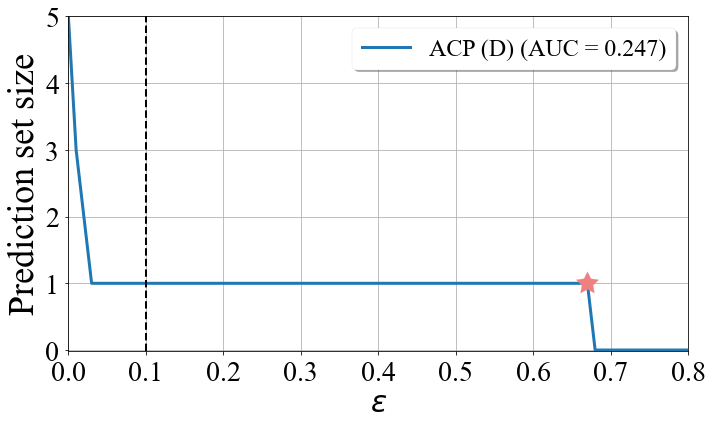

In [10]:
plt.style.use('seaborn-paper')
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10, 6))

plt.plot(epsilons, curve, label ="ACP (D) (AUC = {})".format(AUC), linewidth = 3)
plt.scatter(min_eps, curve[np.where(epsilons == min_eps)[0][0]], s=550, marker=(5, 1), color = "lightcoral", zorder = 3)

plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, np.round(min_eps,1) + 0.1])
plt.ylim([-0.01, N_CLASSES])
plt.xticks(np.arange(0, np.round(min_eps,1) + 0.2, 0.1), fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")
plt.axvline(x=eps, color = "black", linewidth = 2, linestyle = "--")

plt.grid()
plt.tight_layout()

We can measure the efficiency on the whole test set by averaging across points. Again, we report the AUC in $\varepsilon \in [0,0.2]$.

In [11]:
curve_all = epsilon_curves(result, epsilons) #average prediction set size w.r.t epsilon
AUC_all = round(simps(curve_all[:21], epsilons[:21]),3) #AUC

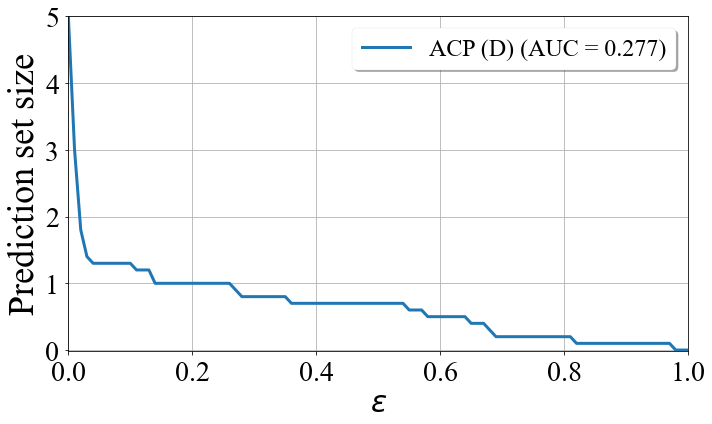

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(epsilons, curve_all, label ="ACP (D) (AUC = {})".format(AUC_all), linewidth = 3)
plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, 1.0])
plt.ylim([-0.01, N_CLASSES])
plt.xticks(fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")

plt.grid()
plt.tight_layout()

$\textbf{EFFICIENCY COMPARISON}$

We now consider main-stream CP alternatives, and compare them empirically with ACP on the basis of their predictive power (efficiency). We study split CP (SCP), RAPS and CV+. We keep the same underlying classifier.

In [13]:
#SCP

from others import split_cp

model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES, 
                      seed = SEED, l2_reg = REG).to(device)
_, _ = split_cp(model, Xtrain, Ytrain, Xtest, labels=np.unique(Ytrain).tolist(), out_file = "results/test_split_cp", 
                validation_split = 0.2)

result_split_cp = pd.read_json("results/test_split_cp", lines = True) #load p-values
curve_all_split_cp = epsilon_curves(result_split_cp, epsilons) #average prediction set size w.r.t epsilon
AUC_all_split_cp = round(simps(curve_all_split_cp[:21], epsilons[:21]),3) #AUC

Epoch: 1 - Validation Loss: 2.5644
Epoch: 10 - Validation Loss: 2.1006
Epoch: 20 - Validation Loss: 1.7861
Epoch: 30 - Validation Loss: 1.5363
Epoch: 40 - Validation Loss: 1.3615
Epoch: 50 - Validation Loss: 1.2511
Epoch: 60 - Validation Loss: 1.1730
Epoch: 70 - Validation Loss: 1.1197
Epoch: 80 - Validation Loss: 1.0747
Epoch: 90 - Validation Loss: 1.0416
Epoch: 100 - Validation Loss: 1.0042
Epoch: 110 - Validation Loss: 0.9823
Epoch: 120 - Validation Loss: 0.9580
Epoch: 130 - Validation Loss: 0.9325
Epoch: 140 - Validation Loss: 0.9197
Epoch: 150 - Validation Loss: 0.9057
Epoch: 160 - Validation Loss: 0.8940
Epoch: 170 - Validation Loss: 0.8828
Epoch: 180 - Validation Loss: 0.8771
Epoch: 190 - Validation Loss: 0.8588


In [14]:
#RAPS

from third_party.RAPS.RAPS_conformal import *

model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES,
                      seed = SEED, l2_reg = REG).to(device)
Xtrain_prop, Xval, Ytrain_prop, Yval = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = SEED)
model.fit(Xtrain_prop, Ytrain_prop, seed = SEED) #training on proper training set
calib_loader = torch.utils.data.DataLoader(create_set(Xval, Yval), batch_size=128, shuffle=True, pin_memory=True) #calib data
sizes = {}
for i, epsilon in enumerate(epsilons): #repeat for each epsilon
    cmodel = ConformalModel(model, calib_loader, alpha=epsilon, lamda_criterion='size', allow_zero_sets=True) #building RAPS
    
    for j in range(len(Ytest)):
        _, set = cmodel(check_tensor(np.expand_dims(Xtest[j], axis=0)).to(device)) #constructing prediction sets
        
        if epsilon not in sizes:
            sizes[epsilon] = [len(list(set[0]))]
        else:
            sizes[epsilon].append(len(list(set[0])))
    
curve_all_RAPS = [np.mean(sizes[epsilon]) for epsilon in sizes] #average prediction set size w.r.t epsilon
AUC_all_RAPS = round(simps(curve_all_RAPS[:21], epsilons[:21]),3) #AUC

Epoch: 1 - Validation Loss: 2.5644
Epoch: 10 - Validation Loss: 2.1006
Epoch: 20 - Validation Loss: 1.7861
Epoch: 30 - Validation Loss: 1.5363
Epoch: 40 - Validation Loss: 1.3615
Epoch: 50 - Validation Loss: 1.2511
Epoch: 60 - Validation Loss: 1.1730
Epoch: 70 - Validation Loss: 1.1197
Epoch: 80 - Validation Loss: 1.0747
Epoch: 90 - Validation Loss: 1.0416
Epoch: 100 - Validation Loss: 1.0042
Epoch: 110 - Validation Loss: 0.9823
Epoch: 120 - Validation Loss: 0.9580
Epoch: 130 - Validation Loss: 0.9325
Epoch: 140 - Validation Loss: 0.9197
Epoch: 150 - Validation Loss: 0.9057
Epoch: 160 - Validation Loss: 0.8940
Epoch: 170 - Validation Loss: 0.8828
Epoch: 180 - Validation Loss: 0.8771


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 110.06it/s]

Epoch: 190 - Validation Loss: 0.8588
Begin Platt scaling.
Computing logits for model (only happens once).



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.45it/s]


Optimal T=1.2971956729888916
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297276258468628


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 250.04it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971363067626953



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.59it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2969298362731934
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974075078964233
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 476.03it/s]


Optimal T=1.297109842300415
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971150875091553
Begin Platt scaling.



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.02it/s]


Computing logits for model (only happens once).
Optimal T=1.296987533569336
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972488403320312
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.92it/s]


Optimal T=1.2974780797958374
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2969958782196045
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 507.54it/s]


Optimal T=1.2971456050872803
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297317385673523


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.44it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297420859336853
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971829175949097



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 504.43it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975765466690063
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297413945198059
Begin Platt scaling.



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 406.68it/s]


Computing logits for model (only happens once).
Optimal T=1.2971147298812866
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2977653741836548
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 590.58it/s]


Optimal T=1.2977522611618042


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 673.08it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970867156982422
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975715398788452
Begin Platt scaling.
Computing logits for model (only happens once).



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 471.43it/s]

Optimal T=1.297539234161377
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2968237400054932
Begin Platt scaling.
Computing logits for model (only happens once).



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 674.54it/s]

Optimal T=1.2974379062652588
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2977049350738525
Begin Platt scaling.
Computing logits for model (only happens once).



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.22it/s]


Optimal T=1.2973968982696533
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2977416515350342
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 659.84it/s]


Optimal T=1.2972973585128784
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976081371307373
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 630.77it/s]


Optimal T=1.297223448753357
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2968311309814453
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.01it/s]


Optimal T=1.2972910404205322
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973709106445312
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 492.14it/s]

Computing logits for model (only happens once).
Optimal T=1.297211766242981
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973929643630981
Begin Platt scaling.
Computing logits for model (only happens once).


Optimal T=1.2972253561019897


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 528.18it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973213195800781
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976253032684326
Begin Platt scaling.



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.71it/s]

Computing logits for model (only happens once).
Optimal T=1.2971044778823853
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970727682113647



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 674.43it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970242500305176
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.29703688621521
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 504.09it/s]


Optimal T=1.2975132465362549
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297073483467102
Begin Platt scaling.
Computing logits for model (only happens once).


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Optimal T=1.2971477508544922
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974647283554077
Begin Platt scaling.
Computing logits for model (only happens once).


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Optimal T=1.2976586818695068
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.29723060131073
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 504.18it/s]


Optimal T=1.2975367307662964
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976878881454468


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 676.12it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971805334091187
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2969812154769897


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.56it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973030805587769
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974345684051514
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 476.19it/s]


Optimal T=1.2976269721984863
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974250316619873
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.62it/s]


Optimal T=1.2972198724746704
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972548007965088
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 680.95it/s]

Optimal T=1.2976083755493164
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971744537353516
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297027826309204



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 489.62it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972875833511353
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972385883331299
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 399.91it/s]


Optimal T=1.2975257635116577
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973202466964722
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.10it/s]


Optimal T=1.2974727153778076
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972954511642456
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 499.74it/s]


Optimal T=1.2975354194641113
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971059083938599
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.05it/s]


Optimal T=1.297417402267456
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2977871894836426
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 675.63it/s]


Optimal T=1.2970141172409058
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2974047660827637
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.45it/s]

Optimal T=1.2971621751785278
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972480058670044
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971594333648682



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.77it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970466613769531
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973941564559937
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.61it/s]

Optimal T=1.2972625494003296
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2977524995803833
Begin Platt scaling.
Computing logits for model (only happens once).



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 538.53it/s]


Optimal T=1.2973322868347168
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976794242858887
Begin Platt scaling.
Computing logits for model (only happens once).


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 669.54it/s]

Optimal T=1.297385573387146
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297310471534729
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970316410064697



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 713.20it/s]


Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973852157592773
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2975223064422607
Begin Platt scaling.


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 490.88it/s]

Computing logits for model (only happens once).
Optimal T=1.2971949577331543
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973690032958984
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973628044128418



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 492.93it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2972244024276733
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2971322536468506



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.01it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973501682281494
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2973374128341675



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 674.16it/s]

Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2976255416870117
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.297223687171936
Begin Platt scaling.



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 500.19it/s]

Computing logits for model (only happens once).
Optimal T=1.2975932359695435
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2970114946365356
Begin Platt scaling.



100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 400.01it/s]

Computing logits for model (only happens once).
Optimal T=1.2971203327178955
Begin Platt scaling.
Computing logits for model (only happens once).
Optimal T=1.2969257831573486


In [15]:
#CV+

from third_party.ARC.arc import models, methods, black_boxes, coverage

model = NeuralNetwork(input_size = N_FEATURES, num_neurons = NUM_NEURONS, out_size = N_CLASSES,
                      seed = SEED, l2_reg = REG).to(device)
method_cv = methods.CVPlus(Xtrain, Ytrain, model, n_folds=5, seed = SEED, verbose = False) #building CV+
sizes = {}

for i, epsilon in enumerate(epsilons): #repeat for each epsilon
        for j in range(len(Ytest)):
            set = method_cv.predict(check_tensor(np.expand_dims(Xtest[j], axis=0)).to(device), alpha = epsilon) #constructing prediction sets
        
            if epsilon not in sizes:
                sizes[epsilon] = [len(list(set[0]))]
            else:
                sizes[epsilon].append(len(list(set[0])))
            
curve_all_CV_plus = [np.mean(sizes[epsilon]) for epsilon in sizes] #average prediction set size w.r.t epsilon
AUC_all_CV_plus = round(simps(curve_all_CV_plus[:21], epsilons[:21]),3) #AUC

Epoch: 1 - Validation Loss: 2.6547
Epoch: 10 - Validation Loss: 2.1409
Epoch: 20 - Validation Loss: 1.8083
Epoch: 30 - Validation Loss: 1.5507
Epoch: 40 - Validation Loss: 1.3418
Epoch: 50 - Validation Loss: 1.2044
Epoch: 60 - Validation Loss: 1.1104
Epoch: 70 - Validation Loss: 1.0377
Epoch: 80 - Validation Loss: 0.9775
Epoch: 90 - Validation Loss: 0.9327
Epoch: 100 - Validation Loss: 0.8972
Epoch: 110 - Validation Loss: 0.8656
Epoch: 120 - Validation Loss: 0.8377
Epoch: 130 - Validation Loss: 0.8122
Epoch: 140 - Validation Loss: 0.7959
Epoch: 150 - Validation Loss: 0.7790
Epoch: 160 - Validation Loss: 0.7645
Epoch: 170 - Validation Loss: 0.7536
Epoch: 180 - Validation Loss: 0.7410
Epoch: 190 - Validation Loss: 0.7327
Epoch: 200 - Validation Loss: 0.7241
Epoch: 1 - Validation Loss: 2.7529
Epoch: 10 - Validation Loss: 2.2280
Epoch: 20 - Validation Loss: 1.9128
Epoch: 30 - Validation Loss: 1.6499
Epoch: 40 - Validation Loss: 1.4725
Epoch: 50 - Validation Loss: 1.3511
Epoch: 60 - Validat

We measure the efficiency with the  AUC in the interval $\varepsilon \in [0,0.2]$ (the lower the AUC; the higher the efficiency). ACP is consistently better than existing alternatives in terms of statistical power: it attains the desired error rate with tighter prediction sets. 

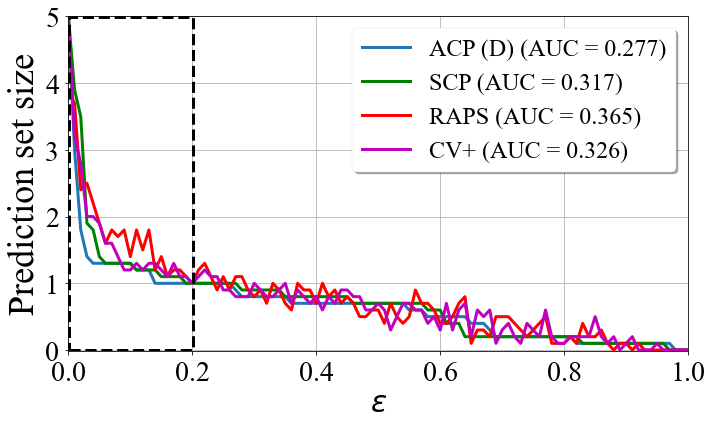

In [16]:
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(epsilons, curve_all, label ="ACP (D) (AUC = {})".format(AUC_all), linewidth = 3)
plt.plot(epsilons, curve_all_split_cp, label ="SCP (AUC = {})".format(AUC_all_split_cp), linewidth = 3, color="green")
plt.plot(epsilons, curve_all_RAPS, label ="RAPS (AUC = {})".format(AUC_all_RAPS), linewidth = 3, color = "red")
plt.plot(epsilons, curve_all_CV_plus, label ="CV+ (AUC = {})".format(AUC_all_CV_plus), linewidth = 3, color = "m")

rect = patches.Rectangle((0.001,0), 0.2, N_CLASSES - 0.01, ls="--", linewidth=3, edgecolor='black', facecolor='none', zorder = 5)
ax.add_patch(rect)

plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, 1.0])
plt.ylim([-0.01, N_CLASSES])
plt.xticks(fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")

plt.grid()
plt.tight_layout()

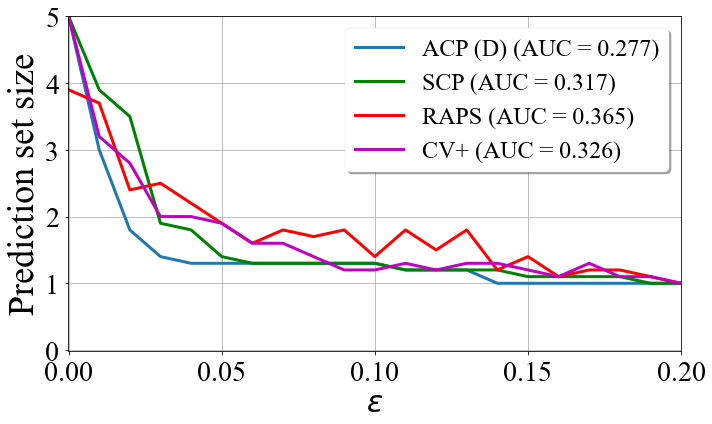

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(epsilons[:21], curve_all[:21], label ="ACP (D) (AUC = {})".format(AUC_all), linewidth = 3)
plt.plot(epsilons[:21], curve_all_split_cp[:21], label ="SCP (AUC = {})".format(AUC_all_split_cp), linewidth = 3, color="green")
plt.plot(epsilons[:21], curve_all_RAPS[:21], label ="RAPS (AUC = {})".format(AUC_all_RAPS), linewidth = 3, color = "red")
plt.plot(epsilons[:21], curve_all_CV_plus[:21], label ="CV+ (AUC = {})".format(AUC_all_CV_plus), linewidth = 3, color = "m")

plt.legend(fontsize = "24", shadow = True, facecolor='white', framealpha=1)
plt.xscale("linear")
plt.xlim([-0.0001, 0.2])
plt.ylim([-0.01, N_CLASSES])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2], fontsize = "28")
plt.yticks(np.arange(N_CLASSES+1).tolist(), fontsize = "28")
plt.ylabel("Prediction set size", fontsize = "36")
plt.xlabel(r"$\epsilon$", fontsize = "30")

plt.grid()
plt.tight_layout()

$\textbf{EXPERIMENTS WITH REAL DATA}$

Let us now see how ACP would perform in CIFAR-10. We load the dataset, apply the pre-processing and optionally reduce the dimensionality of the images with an autoencoder (AE).

In [18]:
from tensorflow.keras.datasets import cifar10

#1-loading cifar-10
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data() 

#2-Applying pre-processing
Xtrain = normalize_flatten(Xtrain) 
Xtest = normalize_flatten(Xtest)
Ytrain = scalar(Ytrain)
Ytest = scalar(Ytest)

#3-We reduce the dimensionality with an AE. Here we set an embedding of size 8
EMBEDDING_SIZE = 8
autoencoder = AE(input_shape=Xtrain.shape[1], embedding_size=EMBEDDING_SIZE, seed = SEED).to(device) 
autoencoder.load_state_dict(torch.load("models/AE_CIFAR-10_"+str(EMBEDDING_SIZE), map_location = 'cuda'))
Xtrain_emb = np.array(autoencoder.embed(Xtrain))
Xtest_emb = np.array(autoencoder.embed(Xtest))

Similarly to the previous experiment, we build ACP using the CIFAR-10 training set.

In [19]:
NUM_NEURONS = [20,10] 
REG = 0.01
model = NeuralNetwork(input_size = Xtrain_emb.shape[1], num_neurons = NUM_NEURONS, out_size = len(np.unique(Ytest)), seed = SEED, l2_reg = REG)
ACP = ACP_D(Xtrain_emb, Ytrain, model, seed = SEED, verbose = True)

Training model on 50000 samples
Epoch: 1 - Validation Loss: 2.6859
Epoch: 10 - Validation Loss: 2.0244
Epoch: 20 - Validation Loss: 1.9764
Epoch: 30 - Validation Loss: 1.9665
Epoch: 40 - Validation Loss: 1.9663
Epoch: 50 - Validation Loss: 1.9619
Computing gradients and Hessian inverse
Computing scores for 50000 samples
Conformal predictor is ready!


Finally, we generate prediction sets for an image chosen uniformly at random. We fix a significance $\varepsilon=0.1$.

In [20]:
cand = random.randint(0, len(Ytest)-1)
eps = 0.1
sets = ACP.predict(Xtest_emb[cand].reshape(1, -1), eps, out_file = "results/CIFAR-10")

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Computing p-values for 1 samples


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:14<00:00, 134.19s/it]


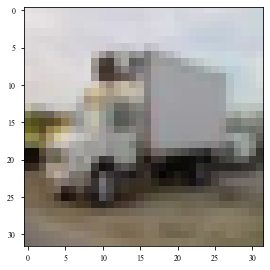


True label: truck
Prediction set: ['airplane', 'automobile', 'ship', 'truck']


In [21]:
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

image = Xtest[cand].reshape(32,32,3)
fig = plt.figure
plt.imshow(image)
plt.show()

print()
print("True label: " + labels[Ytest[cand]])
print("Prediction set: " + str([labels[label] for label in sets[0]]))